# Using my saved model in an example to see if it works

In [25]:
import joblib
import numpy as np
from scipy.sparse import hstack, csr_matrix
import ast
import praw
import time
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# === 1. Load model and vectorizer ===
model = joblib.load("toxicity_model.pkl")
tfidf = joblib.load("Preprocessing.pkl")

In [54]:
# === 2. Set up Reddit API ===
reddit = praw.Reddit(
    client_id="sdf",
    client_secret="sdf",
    user_agent="toxicity-detector by /u/data-anna"
)

# === 3. Define subreddits ===
subreddits = [
    "PoliticalDiscussion",
    "Ask_Politics",
    "ModeratePolitics",
    "NeutralPolitics",
    "Republican",
    "AskTrumpSupporters",
    "AskConservatives",
    "PoliticalHumor",
    "ConservativeMemes",
    "EnoughLibertarianSpam",
    "PoliticalCompassMemes",
    "BuyCanadian",
    "Canada",
    "Conservative",
    "Politics",
    "Worldnews",
    "Democrats",
    "CanadianPolitics",
    "Ontario",
    "vancouver",
    "Alberta",
    "Toronto",
    "Ottawa"
]
# Collect top comments from top posts
comments = []

for sub in subreddits:
    print(f"🔍 Collecting top comments from r/{sub}...")
    count = 0
    try:
        subreddit = reddit.subreddit(sub)
        
        for post in subreddit.top(limit=100, time_filter="all"):  # You can use 'day', 'week', 'month', 'year', 'all'
            post.comments.replace_more(limit=0)  # Skip "load more comments"
            for comment in post.comments:
                if comment.body:  # Ignore deleted/empty comments
                    comments.append({"subreddit": sub, "comment": comment.body})
                    count += 1

        print(f"✅ Collected {count} top comments from r/{sub}")
        
        print("⏳ Waiting 60 seconds to respect Reddit's rate limit...")
        time.sleep(60)

    except Exception as e:
        print(f"❌ Failed to fetch from r/{sub}: {e}")

print(f"\n🎉 Total top comments collected: {len(comments)}")

"""
# === 5. Save to CSV ===
df = pd.DataFrame(comments)
df.to_csv("reddit_comments_with_subreddits.csv", index=False, encoding="utf-8")
print("💾 Saved to 'reddit_comments_with_subreddits.csv'")
"""

import os

df = pd.DataFrame(comments)

file_path = "reddit_comments_with_subreddits.csv"

# Append if file exists, otherwise create new with header
if os.path.exists(file_path):
    df.to_csv(file_path, mode="a", header=False, index=False, encoding="utf-8")
else:
    df.to_csv(file_path, mode="w", header=True, index=False, encoding="utf-8")

print(f"💾 Appended to '{file_path}'")


🔍 Collecting top comments from r/PoliticalDiscussion...
✅ Collected 7237 top comments from r/PoliticalDiscussion
⏳ Waiting 60 seconds to respect Reddit's rate limit...
🔍 Collecting top comments from r/Ask_Politics...
✅ Collected 2496 top comments from r/Ask_Politics
⏳ Waiting 60 seconds to respect Reddit's rate limit...
🔍 Collecting top comments from r/ModeratePolitics...
✅ Collected 4994 top comments from r/ModeratePolitics
⏳ Waiting 60 seconds to respect Reddit's rate limit...
🔍 Collecting top comments from r/NeutralPolitics...
✅ Collected 2816 top comments from r/NeutralPolitics
⏳ Waiting 60 seconds to respect Reddit's rate limit...
🔍 Collecting top comments from r/Republican...
✅ Collected 6228 top comments from r/Republican
⏳ Waiting 60 seconds to respect Reddit's rate limit...
🔍 Collecting top comments from r/AskTrumpSupporters...
✅ Collected 2060 top comments from r/AskTrumpSupporters
⏳ Waiting 60 seconds to respect Reddit's rate limit...
🔍 Collecting top comments from r/AskCons

In [56]:
df = pd.read_csv("reddit_comments_with_subreddits.csv")
df

,subreddit,comment
0,Canada,"All skirt, no knickers. As they say."
1,Canada,"The key word is in your own comment ""Either wa..."
2,Canada,Gasoline is a minor part of oil companies reve...
3,Canada,>DEI establishes quotas which make sure that r...
4,Canada,We all stole the best continent in the world t...
...,...,...
219846,Ottawa,Bhahahaha. God keep our land.. glorious and fr...
219847,Ottawa,It's classless. I wouldn't expect anything els...
219848,Ottawa,This is bad... Orange man will use this as an ...
219849,Ottawa,"No, it's petty. Insane and rude even if you ha..."


In [36]:
comments = df['comment'].tolist() 

In [38]:
# === 3. Preprocess: TF-IDF only (no BERT) ===
X_tfidf = tfidf.transform(comments)

# === 4. Predict ===
predictions = model.predict(X_tfidf)
probs = model.predict_proba(X_tfidf)[:, 1]

# === 5. Show ALL comments with prediction ===
toxic_count = 0
for i in range(len(comments)):
    label = "🔴 Toxic" if predictions[i] == 1 else "🟢 Non-toxic"
    if predictions[i] == 1:
        toxic_count += 1

print(f"\n✅ Total toxic comments found: {toxic_count} out of {len(comments)}")




✅ Total toxic comments found: 642 out of 10081


In [40]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove URLs and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = text.lower()
    words = text.split()
    # Remove stopwords and short words, lemmatize the rest
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

# Apply to only toxic comments
toxic_comments = [comments[i] for i in range(len(comments)) if predictions[i] == 1]
cleaned_toxic_text = " ".join([clean_text(comment) for comment in toxic_comments])


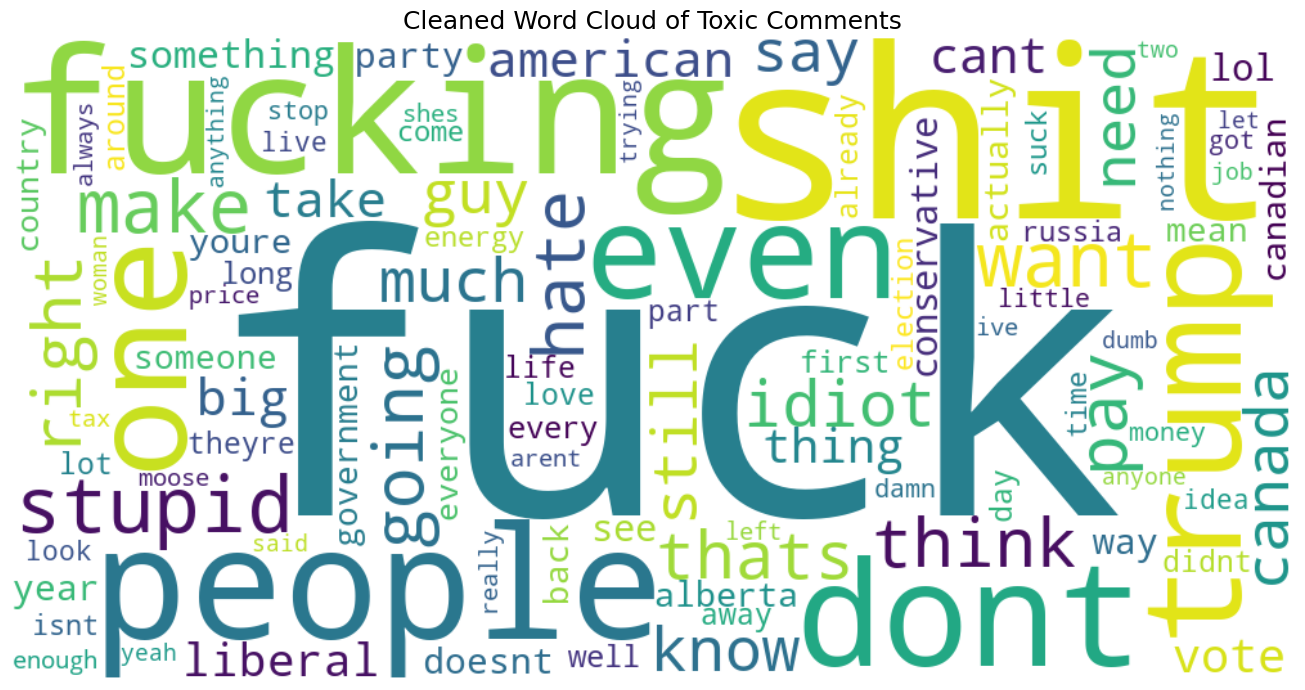

In [42]:
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    max_words=100,
    colormap='viridis',  # try 'plasma', 'inferno', etc. for aesthetics
).generate(cleaned_toxic_text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Cleaned Word Cloud of Toxic Comments", fontsize=18)
plt.tight_layout()
plt.show()



C:\Users\annaj\AppData\Local\Temp\ipykernel_10588\1729952249.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\annaj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


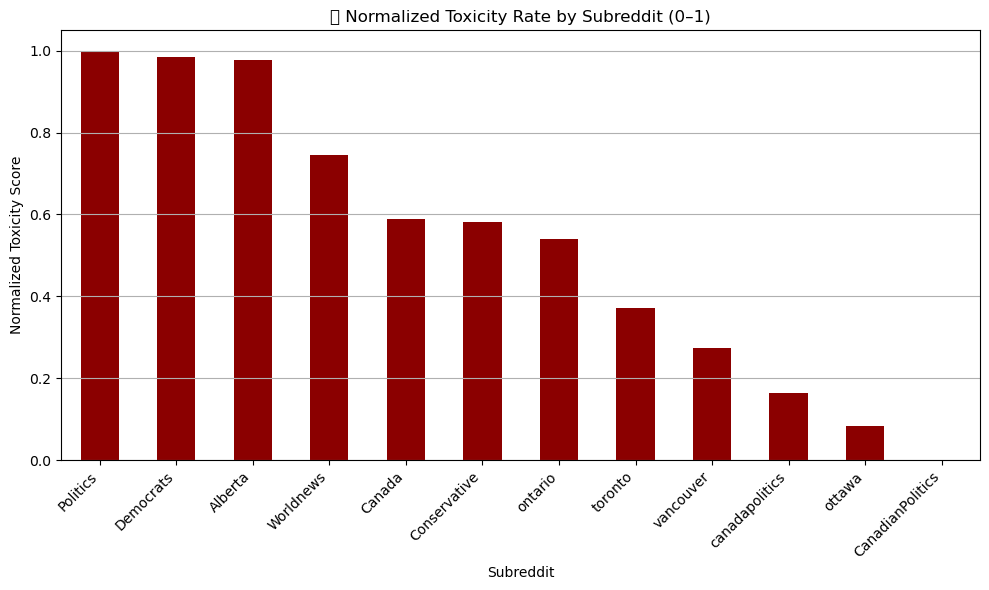

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# === 1. Calculate toxicity rate ===
df['toxicity_label'] = predictions
df['toxicity_prob'] = probs

# Group and count
toxic_counts = df[df['toxicity_label'] == 1].groupby('subreddit').size()
total_counts = df.groupby('subreddit').size()

# Create summary table
toxicity_summary = pd.DataFrame({
    'total_comments': total_counts,
    'toxic_comments': toxic_counts
}).fillna(0)

toxicity_summary['toxicity_rate'] = toxicity_summary['toxic_comments'] / toxicity_summary['total_comments']

# === 2. Normalize toxicity rate (0 to 1) ===
scaler = MinMaxScaler()
toxicity_summary['toxicity_rate_normalized'] = scaler.fit_transform(
    toxicity_summary[['toxicity_rate']]
)

# === 3. Plot normalized toxicity rates ===
toxicity_summary.sort_values('toxicity_rate_normalized', ascending=False).plot(
    kind='bar',
    y='toxicity_rate_normalized',
    legend=False,
    figsize=(10, 6),
    title="📊 Normalized Toxicity Rate by Subreddit (0–1)",
    color='darkred'
)

plt.ylabel("Normalized Toxicity Score")
plt.xlabel("Subreddit")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


